# SCat Algorithm

I have pushed multiple iterations of a simple sequence labeling algorithm called SCat. This iteration is the first version that will be implemented in Kadot to be part of the *Bot Engine*.

The final algorithm use a mono-directional (because we read in only one way) LSTM to encode features from the text and we decode the feature using a simple layer to produce the final classification.

![SCat Algorithm](https://raw.githubusercontent.com/the-new-sky/Kadot/1.0dev/RaD/SCat.jpg "SCat Algorithm")

Let's start by defining our small training dataset.

In [1]:
# Find the city in a weather related query

train_x = [
    "What is the weather like in Paris ?",
    "What kind of weather will it do in London ?",
    "Give me the weather forecast in Berlin please .",
    "Tell me the forecast in New York !",
    "Give me the weather in San Francisco ...",
    "I want the forecast in Dublin ."
]

train_y = [
    ('Paris',),
    ('London',),
    ('Berlin',),
    ('New', 'York'),
    ('San', 'Francisco'),
    ('Dublin',)
]

In [2]:
tokenizer = lambda x: x.split(' ')
vocabulary = sorted(set(tokenizer(' '.join(train_x) + ' <unknown>')))

Now import all the modules we will need.

In [3]:
import torch
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
import numpy as np

It's now time to write our network as described before.

In [4]:
class SCatNetwork(nn.Module):
    def __init__(self, vocabulary_size, embedding_dimension, hidden_size):
        super(SCatNetwork, self).__init__()
        
        self.embeddings = nn.Embedding(vocabulary_size, embedding_dimension)
        self.encoder = nn.LSTM(  # a LSTM layer to encode features
            embedding_dimension,
            hidden_size,
            batch_first=True,
        )
        self.decoder = nn.Linear(hidden_size, 2)
    
    def forward(self, inputs):
        hc = (Variable(torch.ones(1, 1, 10)), Variable(torch.ones(1, 1, 10)))
        
        outputs = self.embeddings(inputs)
        outputs, _ = self.encoder(outputs, hc)    
        outputs = self.decoder(outputs)
        return outputs

We will also need a function to transform a sentence into a list (LongTensor) of index.

In [5]:
def vectorizer(sentence):
    tokens = tokenizer(sentence)
    vector = [vocabulary.index(token) if token in vocabulary else vocabulary.index('<unknown>') for token in tokens]
    
    return torch.LongTensor(vector)            

Before training, let's test the whole network.

In [6]:
print(train_x[0])

test_vec = Variable(vectorizer(train_x[0]).view(1, len(tokenizer(train_x[0]))))
test_net = SCatNetwork(len(vocabulary), 20, 10)

print(test_vec)
print(str(test_net))
print()

test_net(test_vec)

What is the weather like in Paris ?
Variable containing:
   15    20    27    29    23    19    12     4
[torch.LongTensor of size 1x8]

SCatNetwork(
  (embeddings): Embedding(31, 20)
  (encoder): LSTM(20, 10, batch_first=True)
  (decoder): Linear(in_features=10, out_features=2, bias=True)
)



Variable containing:
(0 ,.,.) = 
  0.1471  0.0173
  0.0750  0.0669
 -0.0199 -0.0658
 -0.0773 -0.2239
  0.0530 -0.2327
 -0.1172 -0.2223
 -0.0828 -0.2067
  0.0318 -0.1589
[torch.FloatTensor of size 1x8x2]

Now let's train the network with those hyperparameters :

 - **epoch** : 800
 - **learning rate** : 0.01
 - **optimizer** : Adam
 - **Loss function** : Cross-Entropy
 - **embedding dimension** : 20
 - **hidden layer size** : 10
 - **min probability tolerance** : 0.0001
 - **mean output ratio** : 75%
 - **N-gram range**: 1 - 10

In [7]:
n_epoch = 801
learning_rate = 0.01
mean_ratio = 0.75
min_tolerance = 1e-04
n_range = (1, 10+1)

model = SCatNetwork(len(vocabulary), 20, 10)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

for epoch in range(n_epoch):
    epoch_losses = []
    
    for sentence, goal in zip(train_x, train_y):
        sentence_lenght = len(tokenizer(sentence))
        goal = [1 if word in goal else 0 for word in tokenizer(sentence)]
        
        x = Variable(vectorizer(sentence).view(1, sentence_lenght))
        y = Variable(torch.LongTensor(goal))
        
        model.zero_grad()
        
        preds = model(x)[0]
        loss = criterion(preds, y)
        epoch_losses.append(float(loss))
        
        loss.backward()
        optimizer.step()
        
    if epoch % 80 == 0:
        mean_loss = torch.FloatTensor(epoch_losses).mean()
        print("Epoch {} - Loss : {}".format(epoch, float(mean_loss)))

Epoch 0 - Loss : 0.638474315404892
Epoch 80 - Loss : 0.0003119074899586849
Epoch 160 - Loss : 9.471087954201114e-05
Epoch 240 - Loss : 4.483968010996856e-05
Epoch 320 - Loss : 2.5974186125192016e-05
Epoch 400 - Loss : 1.6693455563654425e-05
Epoch 480 - Loss : 1.1401202148893693e-05
Epoch 560 - Loss : 8.116763865473331e-06
Epoch 640 - Loss : 5.943054247836699e-06
Epoch 720 - Loss : 4.4373889143874594e-06
Epoch 800 - Loss : 3.360752922768976e-06


Now let's test the model with this sentence : *Give me the latest weather forecast in Los Angeles*

In [8]:
x = "Give me the latest weather forecast in Los Angeles"
tokens = tokenizer(x)
x_vec = Variable(vectorizer(x).view(1, len(tokens)))

pred = F.softmax(model(x_vec), dim=2)[0, :,1].data

Visualize the output of the network and apply a special transformation to it.

<Container object of 9 artists>

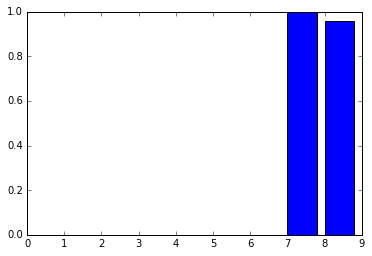

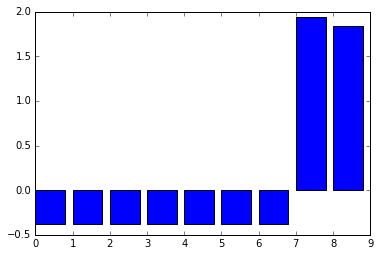

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.bar(range(len(pred)), pred.tolist())

# Apply the special transformation
pred = (pred - min_tolerance - mean_ratio * pred.mean()) / pred.std()

plt.figure()
plt.bar(range(len(pred)), pred.tolist())

In [10]:
word_with_scores = list(zip(tokens, pred.tolist()))
word_with_scores

[('Give', -0.37811943888664246),
 ('me', -0.37811994552612305),
 ('the', -0.37812015414237976),
 ('latest', -0.37789979577064514),
 ('weather', -0.3781139552593231),
 ('forecast', -0.37811869382858276),
 ('in', -0.37810349464416504),
 ('Los', 1.9355530738830566),
 ('Angeles', 1.8426263332366943)]

Finally, find the most scored n-gram in the sentence.

In [11]:
grams_with_scores = sum([list(zip(*[word_with_scores[i:] for i in range(n)])) for n in range(*n_range)], [])
grams_with_scores.append([('', 0)])

summed_gram_scores = [sum(list(zip(*gram))[1]) for gram in grams_with_scores]

best_gram = list(grams_with_scores[summed_gram_scores.index(max(summed_gram_scores))])
best_gram

[('Los', 1.9355530738830566), ('Angeles', 1.8426263332366943)]